In [2]:
import torch
from torch import Tensor
from torchvision import transforms

from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib.animation as animation

import numpy as np
from tqdm import tqdm
import multiprocessing

import os

from dlp.dataset import Dataset
from parksim.trajectory_predict.intent_transformer.network import TrajectoryPredictorWithIntent
from parksim.trajectory_predict.data_processing.utils import TransformerDataProcessor

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if DEVICE == "cuda":
    torch.cuda.empty_cache()


In [3]:
def build_trajectory_predict_from_config(config, input_shape=(3, 100, 100)):
    model = TrajectoryPredictorWithIntent(
        input_shape=input_shape,
        dropout=config['dropout'], 
        num_heads=config['num_heads'], 
        num_encoder_layers=config['num_encoder_layers'], 
        num_decoder_layers=config['num_decoder_layers'], 
        dim_model=config['dim_model'],
        d_hidden=config['d_hidden'],
        num_conv_layers=config['num_conv_layers']
    )
    return model

# Load Model and Dataset

In [4]:
MODEL_PATH = "models\Intent_Transformer_04-01-2022_18-09-17.pth"
config={
        'dim_model' : 24,
        'num_heads' : 6,
        'dropout' : 0.41,
        'num_encoder_layers' : 16,
        'num_decoder_layers' : 4,
        'd_hidden' : 512,
        'num_conv_layers' : 6,
        'lr' : 0.1
}

model = build_trajectory_predict_from_config(config)
model_state = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(model_state)
model.eval().to(DEVICE)

img_transform=transforms.ToTensor()

In [5]:
dji_num = '0012'

home_path = Path.home() / 'Documents/GitHub'
# Load dataset
ds = Dataset()
ds.load(str(home_path / f'dlp-dataset/data/DJI_{dji_num}'))

extractor = TransformerDataProcessor(ds=ds)

In [6]:
scene = ds.get('scene', ds.list_scenes()[0])
agents = scene['agents']

In [7]:
def generate_data_for_agent_in_range(agent_token: str, extractor: TransformerDataProcessor, instances, start_idx: int, stride: int=10, history: int=10, future: int=10, img_size: int=100):
    all_image_history = []
    all_trajectory_history = []
    all_trajectory_future = []
    all_trajectory_future_tgt = []
    all_local_intent_pose = []
    all_inst_centric_view = []
    inst_idx = start_idx
    curr_instance = instances[inst_idx]
    inst_token = curr_instance['instance_token']
    img_frame = extractor.vis.plot_frame(curr_instance['frame_token'])
    image_feature = extractor.vis.inst_centric(img_frame, inst_token)

    global_intent_pose = extractor.get_intent_pose(
        inst_token=inst_token, inst_centric_view=image_feature)

    image_feature = extractor.label_target_spot(inst_token, image_feature)

    all_inst_centric_view = image_feature.copy()

    curr_pose = np.array([curr_instance['coords'][0],
                            curr_instance['coords'][1], curr_instance['heading']])
    rot = np.array([[np.cos(-curr_pose[2]), -np.sin(-curr_pose[2])],
                [np.sin(-curr_pose[2]), np.cos(-curr_pose[2])]])

    local_intent_coords = np.dot(rot, global_intent_pose[:2]-curr_pose[:2])
    local_intent_pose = np.array(
        [local_intent_coords[0], local_intent_coords[1], global_intent_pose[2]-curr_pose[2]])
    local_intent_pose = np.expand_dims(local_intent_pose, axis=0)

    image_history = []
    trajectory_history = []
    for i in range(inst_idx - stride * (history - 1), inst_idx+1, stride):
        instance = instances[i]
        pos = np.array(instance['coords'])
        translated_pos = np.dot(rot, pos-curr_pose[:2])
        trajectory_history.append(Tensor(
            [translated_pos[0], translated_pos[1], instance['heading'] - curr_pose[2]]))

        # generate image history
        img_frame = extractor.vis.plot_frame(instance['frame_token'])
        image_feature = extractor.vis.inst_centric(
            img_frame, instance['instance_token'], curr_pose)
        image_feature = extractor.label_target_spot(
            inst_token, image_feature, curr_pose)

        # Image transformation
        image_tensor = img_transform(image_feature.resize((img_size, img_size)))
        image_history.append(image_tensor)
    
    trajectory_future = []
    for i in range(inst_idx + stride, inst_idx + stride * future + 1, stride):
        instance = instances[i]
        pos = np.array(instance['coords'])
        translated_pos = np.dot(rot, pos-curr_pose[:2])
        trajectory_future.append(Tensor(
            [translated_pos[0], translated_pos[1], instance['heading'] - curr_pose[2]]))
    
    all_image_history = torch.stack(image_history)
    all_trajectory_history = torch.stack(trajectory_history)
    # This is the tgt that is passed into the decoder, and trajectory_future is the label
    trajectory_future_tgt = torch.stack(
        trajectory_history[-1:] + trajectory_future[:-1])
    all_trajectory_future_tgt = trajectory_future_tgt
    all_trajectory_future = torch.stack(trajectory_future)
    all_local_intent_pose = torch.from_numpy(local_intent_pose)

    return all_image_history, all_trajectory_history, all_local_intent_pose, all_trajectory_future_tgt, all_trajectory_future, all_inst_centric_view

def generate_data_for_agent(agent_token: str, extractor: TransformerDataProcessor, stride: int=10, history: int=10, future: int=10, img_size: int=100):
    instances = ds.get_agent_instances(agent_token)
    start_idx = history * stride
    end_idx = (len(instances) - 1 - future * stride) // 100
    all_inputs = [(agent_token, extractor, instances, start_idx + i * future * stride, stride, history, future, img_size) for i in range(end_idx - start_idx)]
    print(len(all_inputs))
    with multiprocessing.Pool(processes=32) as pool:
        result = pool.starmap(generate_data_for_agent_in_range, all_inputs)
        print("HERE")
    get_ith_index_list = lambda i : lambda t : t[i]
    return torch.stack(map(get_ith_index_list(0), result)), torch.stack(map(get_ith_index_list(1), result)), torch.stack(map(get_ith_index_list(2), result)), torch.stack(map(get_ith_index_list(3), result)), torch.stack(map(get_ith_index_list(4), result)), map(get_ith_index_list(5), result)


    


In [8]:
def draw_prediction(idx):
    sensing_limit = 20

    inst_centric_view = list_inst_centric_view[idx]

    img_size = inst_centric_view.size[0] / 2

    traj_hist_pixel = X[idx, :, :2].detach().cpu().numpy() / \
        sensing_limit*img_size + img_size

    traj_future_pixel = y_label[idx, :, :2].detach().cpu().numpy() / \
        sensing_limit*img_size + img_size

    intent_pixel = intent[idx, 0, :2].detach().cpu().numpy() / \
        sensing_limit*img_size + img_size

    traj_pred_pixel = pred[idx, :, :2].detach().cpu().numpy() / \
        sensing_limit*img_size + img_size

    plt.cla()

    plt.imshow(inst_centric_view)
    plt.plot(traj_hist_pixel[:, 0], traj_hist_pixel[:, 1], 'k', linewidth=2)
    plt.plot(traj_future_pixel[:, 0], traj_future_pixel[:,
            1], 'wo', linewidth=2, markersize=2)
    plt.plot(traj_pred_pixel[:, 0], traj_pred_pixel[:, 1],
            'g^', linewidth=2, markersize=2)
    plt.plot(intent_pixel[0], intent_pixel[1], '*', color='C1', markersize=8)
    plt.axis('off')


# Single Agent

In [9]:
agent_token = agents[6]
print(ds.get('agent', agent_token)['type'])
img, X, intent, y_in, y_label, list_inst_centric_view = generate_data_for_agent(agent_token=agent_token, extractor=extractor)
with torch.no_grad():
    img = img.to(DEVICE).float()
    X = X.to(DEVICE).float()
    intent = intent.to(DEVICE).float()
    y_in = y_in.to(DEVICE).float()
    y_label = y_label.to(DEVICE).float()
    tgt_mask = model.transformer.generate_square_subsequent_mask(
        y_in.shape[1]).to(DEVICE).float()

    pred = model(img, X, intent, y_in, tgt_mask=tgt_mask)

Car
12


## Single frame

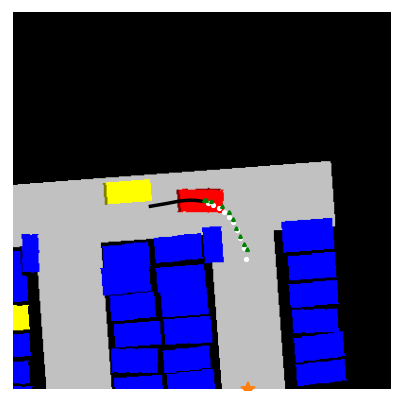

In [ ]:
frame_i = 0
fig = plt.figure()

draw_prediction(frame_i)
plt.show()


## Animation

In [10]:
fig = plt.figure()

anim = animation.FuncAnimation(fig, draw_prediction, frames=pred.shape[0],
                               interval=0.4)
fname = 'C:\\Users\\rlaca\\Documents\\GitHub\\ParkSim\\python\\parksim\\trajectory_predict\\intent_transformer\\animation.mp4'
video_writer = animation.FFMpegWriter(fps=2)
anim.save(fname, writer=video_writer)


NameError: name 'list_inst_centric_view' is not defined

<Figure size 750x500 with 0 Axes>

# Generate Animations for all agents

In [ ]:
if not os.path.exists('./animations'):
    os.mkdir('./animations')

for i, agent_token in enumerate(agents):
    if ds.get('agent', agent_token)['type'] in {'Pedestrian', 'Undefined'}:
        continue
    
    print(f'===== Generating animation for agent {i} / {len(agents)} ======')

    try:

        with torch.no_grad():
            img, X, intent, y_in, y_label, list_inst_centric_view = generate_data_for_agent(
            agent_token=agent_token, extractor=extractor)
            
            img = img.to(DEVICE).float()
            X = X.to(DEVICE).float()
            intent = intent.to(DEVICE).float()
            y_in = y_in.to(DEVICE).float()
            y_label = y_label.to(DEVICE).float()
            tgt_mask = model.transformer.generate_square_subsequent_mask(
                y_in.shape[1]).to(DEVICE).float()

            pred = model(img, X, intent, y_in, tgt_mask=tgt_mask)

        fig = plt.figure()

        anim = animation.FuncAnimation(fig, draw_prediction, frames=pred.shape[0],
                                    interval=0.1)

        fname = f'./animations/DJI_{dji_num}-Agent_{i}.mp4'
        video_writer = animation.FFMpegWriter(fps=10)
        anim.save(fname, writer=video_writer)

    except:
        print(f'Get error at agent {i}')
